In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5729818.datarmor0/parcels-502090/libparcels_random_b0ebabb4-f906-4134-8761-eca9fbf35a7e.so


In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=3
#                 )
#
client = Client(cluster)

In [4]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_california")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)



In [5]:
ds = xr.open_zarr(llc_zarr)

In [6]:
ds['zonal_velocity_var'] = (ds['zonal_velocity']-ds['zonal_velocity'].mean('time'))**2
ds['meridional_velocity_var'] = (ds['meridional_velocity']-ds['meridional_velocity'].mean('time'))**2

In [7]:
ds_mean = ds.mean('time').compute()

dfE_mean = ds_mean.drop(['face']).to_dataframe()

In [139]:
bbox = [-128, -118, 30, 40] # california


dl = 1.  #2.
lonmin,lonmax = bbox[0],bbox[1]
latmin,latmax = bbox[2],bbox[3]
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

In [140]:
dfE_mean['lon_cut'] = pd.cut(dfE_mean['lon'], lon)
dfE_mean['lat_cut'] = pd.cut(dfE_mean['lat'], lat)

In [31]:
df_sub = dfE_mean.groupby(['lat_cut'])

In [141]:
df_sub = dfE_mean[dfE_mean.lat_cut==dfE_mean.lat_cut.values[100000]]

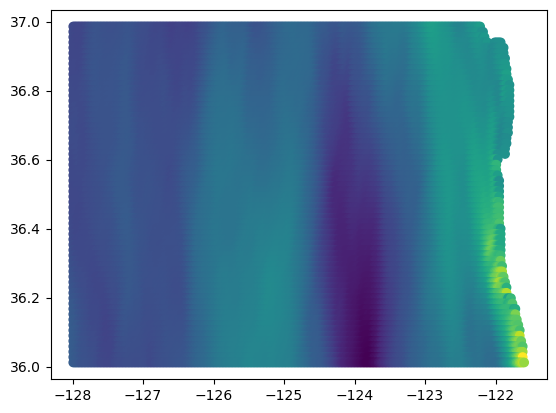

In [142]:
plt.scatter(df_sub.lon,df_sub.lat,c=df_sub.meridional_velocity)

In [143]:
df_sub

Depth        lat         lon  meridional_velocity  \
i    j                                                              
2964 0    4770.004395  36.986065 -127.989586            -0.122654   
     1    4766.751953  36.986065 -127.968750            -0.124528   
     2    4674.879883  36.986065 -127.947914            -0.126054   
     3    4766.751953  36.986065 -127.927086            -0.127094   
     4    4766.751953  36.986065 -127.906250            -0.127851   
...               ...        ...         ...                  ...   
3027 475     0.000000  36.012012 -118.093750                  NaN   
     476     0.000000  36.012012 -118.072914                  NaN   
     477     0.000000  36.012012 -118.052086                  NaN   
     478     0.000000  36.012012 -118.031250                  NaN   
     479     0.000000  36.012012 -118.010414                  NaN   

          zonal_velocity           lon_cut       lat_cut  
i    j                                                    
2964 0         -0.066854  (-128.0, -127.0]  (36.0, 37.0]  
     1         -0.067238  (-128.0, -127.0]  (36.0, 37.0]  
     2         -0.067735  (-128.0, -127.0]  (36.0, 37.0]  
     3         -0.068230  (-128.0, -127.0]  (36.0, 37.0]  
     4         -0.068517  (-128.0, -127.0]  (36.0, 37.0]  
...                  ...               ...           ...  
3027 475             NaN               NaN  (36.0, 37.0]  
     476             NaN               NaN  (36.0, 37.0]  
     477             NaN               NaN  (36.0, 37.0]  
     478             NaN               NaN  (36.0, 37.0]  
     479             NaN               NaN  (36.0, 37.0]  

[30720 rows x 7 columns]

In [156]:
df_lonlat = df_sub.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [147]:
df_lat = dfE_mean.groupby(['lat_cut']).apply(lambda x:x.mean(skipna=True))

In [105]:
df_lonlat_count = df_sub.groupby(['lon_cut','lat_cut']).count()

In [106]:
df_lonlat_count = pa.add_geodata(df_lonlat_count,lonlat=['lon_cut','lat_cut'])
df_lonlat_count = (df_lonlat_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])['zonal_velocity']
         .to_xarray()
        )

In [157]:
df_lonlat = pa.add_geodata(df_lonlat,lonlat=['lon_cut','lat_cut'])
df_lonlat = (df_lonlat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

In [148]:
df_lat = pa.add_geodata(df_lat,lonlat=['lat_cut'])
df_lat = (df_lat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lat_cut']])
         .to_xarray()
        )

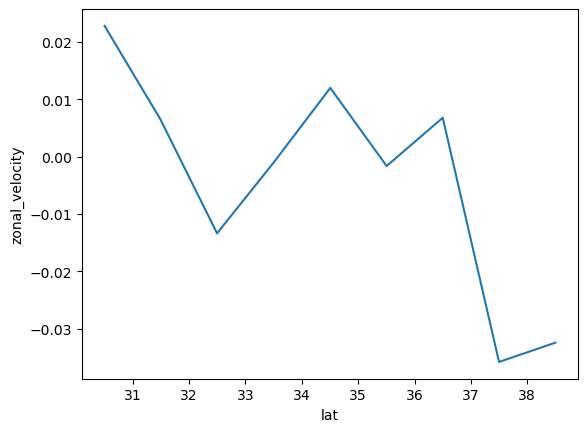

In [151]:
df_lat.zonal_velocity.plot()

(36.0, 37.0)

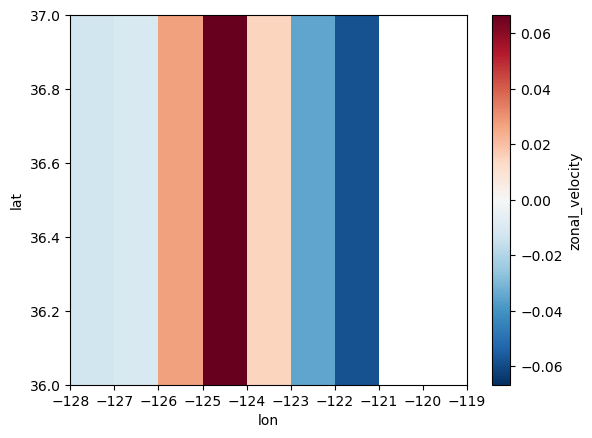

In [116]:
df_lonlat.zonal_velocity.plot(y='lat')
plt.ylim(36,37)

(-128.0, -119.0)

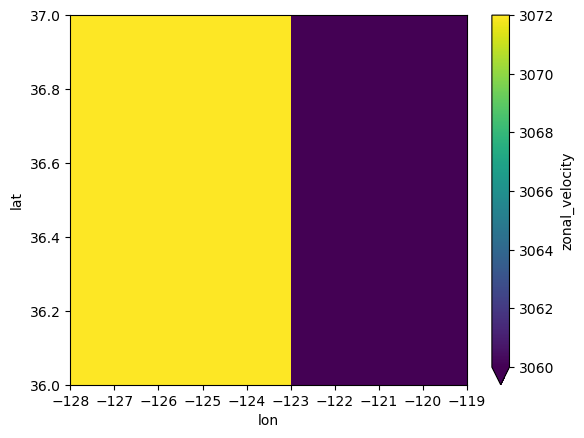

In [164]:
df_lonlat_count.plot(y='lat',vmin=3060)
plt.ylim(36,37);plt.xlim()

In [158]:
df_lonlat.zonal_velocity.mean(dim='lon',skipna=True).isel(lat=6)

<xarray.DataArray 'zonal_velocity' ()>
array(0.01711603)
Coordinates:
    lat      float64 36.5

In [155]:
df_lat.zonal_velocity.isel(lat=6)

<xarray.DataArray 'zonal_velocity' ()>
array(0.00678267)
Coordinates:
    lat      float64 36.5

In [78]:
from xhistogram.xarray import histogram

N = histogram(ds_mean.lon.load(), ds_mean.lat.load(), 
                bins=[lon, lat], 
                dim=['i', 'j'], 
                block_size=None
                     )

In [79]:
E_u = histogram(ds_mean.lon.load(), ds_mean.lat.load(),bins=[lon, lat], 
                      weights= ds_mean["zonal_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_u = (E_u/N).rename('E_%s'%('zonal_velocity')).rename({'lon_bin': 'lon','lat_bin': 'lat'})    

In [84]:
N_lat = histogram(ds_mean.lat.load(), 
                bins=[lat], 
                dim=['i', 'j'], 
                block_size=None
                     )
E_u_lat = histogram(ds_mean.lat.load(),bins=[lat], 
                      weights= ds_mean["zonal_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_u_lat = (E_u_lat/N_lat).rename('E_%s'%('zonal_velocity')).rename({'lat_bin': 'lat'})    

In [86]:
E_v_lat = histogram(ds_mean.lat.load(),bins=[lat], 
                      weights= ds_mean["meridional_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_v_lat = (E_v_lat/N_lat).rename('E_%s'%('meridional_velocity')).rename({'lat_bin': 'lat'})    

In [80]:
E_v = histogram(ds_mean.lon.load(), ds_mean.lat.load(),bins=[lon, lat], 
                      weights= ds_mean["meridional_velocity"].load(), 
                      dim=['i', 'j'], 
                      block_size=None
                     )

        # get binned results
E_v = (E_v/N).rename('E_%s'%('meridional_velocity')).rename({'lon_bin': 'lon','lat_bin': 'lat'})    

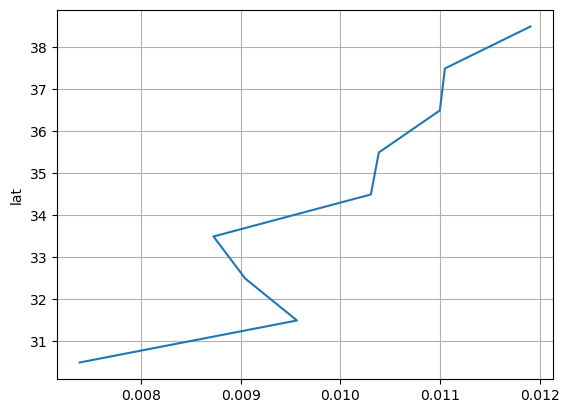

In [32]:
(E_u**2+E_v**2).mean('lon').plot(y='lat')
plt.grid()

In [ ]:
ds_mean['MKE'] = ds_mean['zonal_velocity']**2+ds_mean['meridional_velocity']**2

In [221]:
def binned_mean(df,dl,bbox,k,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]
    latmin,latmax = bbox[2],bbox[3]
    lon = np.arange(lonmin,lonmax+dl, dl)
    lat = np.arange(latmin, latmax+dl, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    #df_count = df.groupby(group).apply(lambda x:x.count())
    #df_count = pa.add_geodata(df_count,lonlat=group)
    #f_count = (df_count
     #     .drop(columns=['Coordinates'])
    #      .set_index([V.split('_')[0] for V in group])
    #     .to_xarray()
    #    )
    #df_count = df_count.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    if len(group)==1:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=True))
    else:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=skipna))
    df = pa.add_geodata(df,lonlat=group)
    df = (df
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    #df = df.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    #df['count'] = df_count.zonal_velocity
    #df = df.assign_coords({'lat':np.around(df.lat,decimals=k)
    #                                                 ,'lon':np.around(df.lon,decimals=k)})
    return df

In [222]:
def binned_Lmean(df,dl,bbox,group,skipna=False):
    lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
    latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax+dl, dl)
    lat = np.arange(latmin, latmax+dl, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_reset = df.reset_index()
    #group = ['lon_cut','lat_cut']
    #df_count = df.groupby(group).count()
    #df_count = pa.add_geodata(df_count,lonlat=group)
    #df_count = (df_count
     #     .drop(columns=['Coordinates'])
    #      .set_index([V.split('_')[0] for V in group])
    #     .to_xarray()
    #    )
    df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=skipna))
    df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})
    df_merged = (df_reset
                 .merge(df_mean.reset_index(), on=group)
                )
    df_merged = df_merged.set_index('time')
    for V in ['zonal_velocity','meridional_velocity']:
        df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
        df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
        df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
    df_merged['MKE_itime'] = df_merged['zonal_velocity_mean']**2+df_merged['meridional_velocity_mean']**2
    df_merged['KE'] = df_merged['zonal_velocity']**2+df_merged['meridional_velocity']**2
    #dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))
    #dfL_mean = pa.add_geodata(dfL_mean)
    #dfL_mean = (dfL_mean
    #          .set_index(['lon', 'lat'])
    #         .to_xarray()
    #        )
    if len(group)==1:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=True))
    else:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=skipna))
    dfL_mean = pa.add_geodata(dfL_mean,lonlat=group)
    dfL_mean = (dfL_mean
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    #dfL_mean['count'] = df_count.zonal_velocity
    return dfL_mean,df_merged#,df_count

In [97]:
ds_mean

<xarray.Dataset>
Dimensions:                  (i: 636, j: 480)
Coordinates:
    Depth                    (j, i) float32 4.499e+03 4.513e+03 ... 3.289e+03
    face                     int64 10
  * i                        (i) int64 2765 2766 2767 2768 ... 3398 3399 3400
  * j                        (j) int64 0 1 2 3 4 5 6 ... 474 475 476 477 478 479
Data variables:
    lat                      (j, i) float64 39.99 39.97 39.96 ... 30.03 30.01
    lon                      (j, i) float64 -128.0 -128.0 ... -118.0 -118.0
    meridional_velocity      (j, i) float32 -0.06508 -0.06529 ... -0.1015
    zonal_velocity           (j, i) float32 0.06416 0.06495 ... 0.04006 0.03535
    zonal_velocity_var       (j, i) float32 0.02442 0.0258 ... 0.01273 0.01234
    meridional_velocity_var  (j, i) float32 0.02564 0.02778 ... 0.01154 0.0115

#### Test Eulerian differences lat_cut or [lon_cut,lat_cut]

In [10]:
bbox = [-128, -118, 30, 40] # california
dl=1.
group = ['lon_cut','lat_cut']
#dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl_skipna = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=False)
dfE_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])

In [92]:
for V in [dfE_1dl_skipna,dfE_1dl,dfE_1dlat]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
    V['MKE'] = V['zonal_velocity']**2+V['meridional_velocity']**2
    #V['EKE'] = V['zonal_velocity_var']+V['meridional_velocity_var']

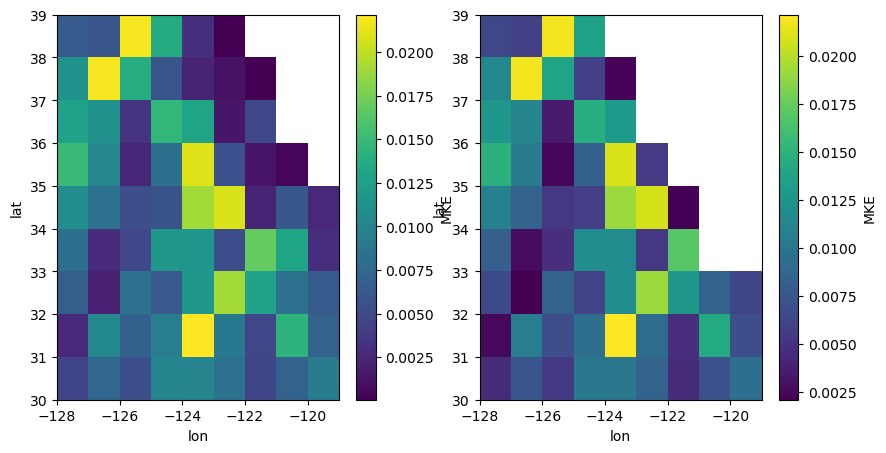

In [93]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
dfE_1dl_skipna.MKE.plot(y='lat',ax=ax[0])
dfE_1dl.MKE.plot(y='lat',ax=ax[1])

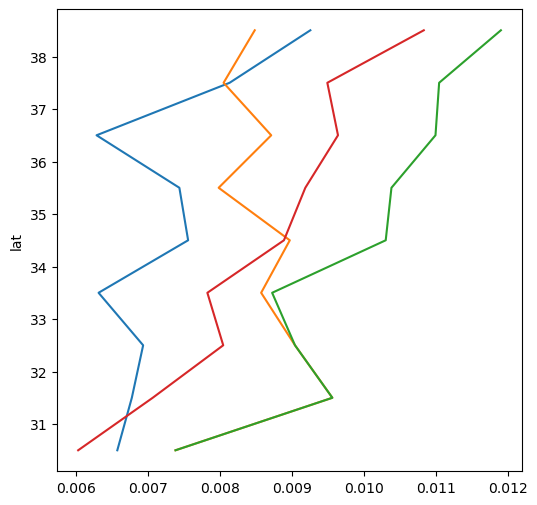

In [54]:
fig,ax = plt.subplots(figsize=(6,6))
dfE_1dlat.MKE.plot(ax=ax,y='lat',label='')
dfE_1dl_skipna.mean('lon').MKE.plot(ax=ax,y='lat')
dfE_1dl.MKE.mean('lon').plot(ax=ax,y='lat')
(E_u.mean('lon')**2+E_v.mean('lon')**2).plot(ax=ax,y='lat')

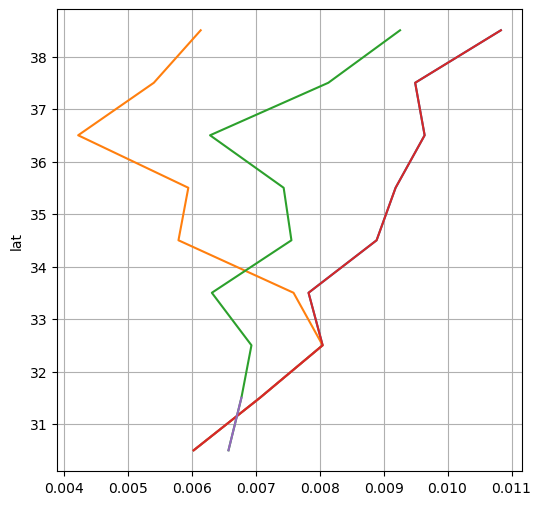

In [94]:
fig,ax = plt.subplots(figsize=(6,6))
(dfE_1dl.zonal_velocity.mean('lon')**2+dfE_1dl.meridional_velocity.mean('lon')**2).plot(ax=ax,y='lat')
(dfE_1dl_skipna.zonal_velocity.mean('lon')**2+dfE_1dl_skipna.meridional_velocity.mean('lon')**2).plot(ax=ax,y='lat')
dfE_1dlat.MKE.plot(ax=ax,y='lat',label='')
(E_u.mean('lon')**2+E_v.mean('lon')**2).plot(ax=ax,y='lat')
(E_u_lat**2+E_v_lat**2).plot(ax=ax,y='lat')


ax.grid()

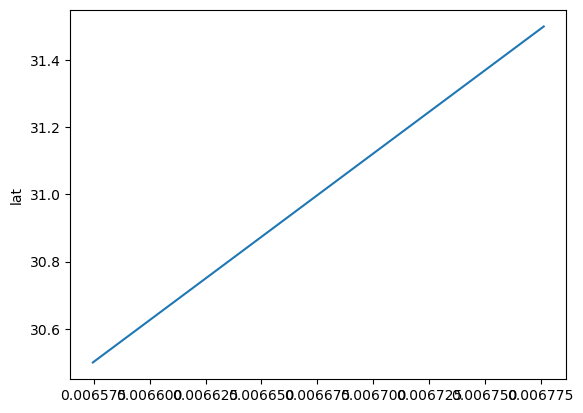

In [95]:
(E_u_lat**2+E_v_lat**2).plot(y='lat')



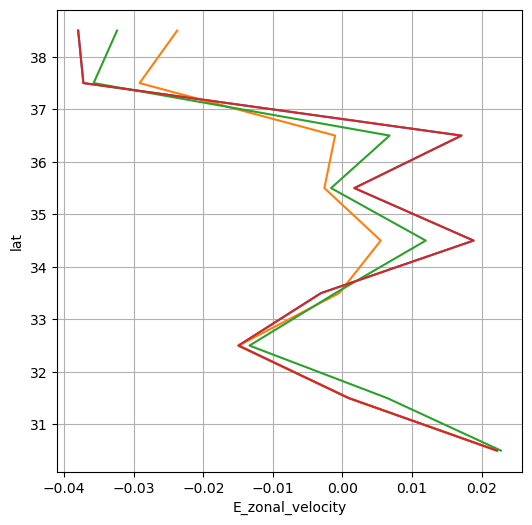

In [57]:
fig,ax = plt.subplots(figsize=(6,6))
(dfE_1dl.zonal_velocity.mean('lon')).plot(ax=ax,y='lat')
(dfE_1dl_skipna.zonal_velocity.mean('lon')).plot(ax=ax,y='lat')
dfE_1dlat.zonal_velocity.plot(ax=ax,y='lat',label='')
(E_u.mean('lon')).plot(ax=ax,y='lat')

ax.grid()

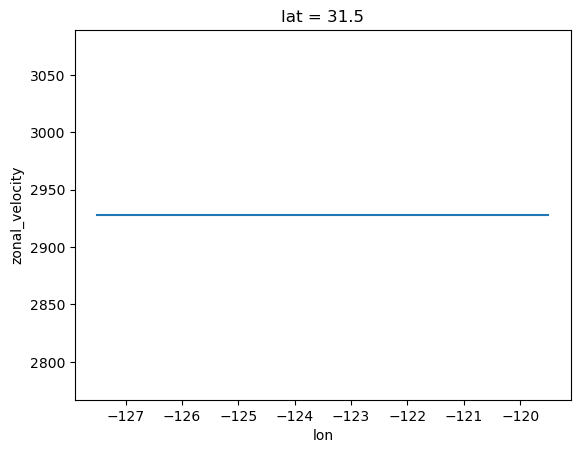

In [68]:
_dfE_count.zonal_velocity.isel(lat=1).plot()

In [59]:
_dfE_mean = dfE_mean.copy()
lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)
#_dfE_mean['lon'] = (_dfE_mean['lon']+180)%360 - 180
_dfE_mean['lon_cut'] = pd.cut(_dfE_mean['lon'], lon)
_dfE_mean['lat_cut'] = pd.cut(_dfE_mean['lat'], lat)
#df_reset = _dfE_mean.reset_index()

In [87]:
_dfE_mean = _dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.mean(skipna=False))

In [88]:
_dfE_mean_lat = _dfE_mean.groupby(['lat_cut']).mean()

In [81]:
_dfE_mean_lat

,Depth,lat,lon,meridional_velocity,zonal_velocity,zonal_velocity_var,meridional_velocity_var
lat_cut,,,,,,,
"(30.0, 31.0]",4058.078315,30.501771,-123.5,-0.074412,0.022211,0.012992,0.014726
"(31.0, 32.0]",3989.212836,31.496087,-123.5,-0.084057,0.000906,0.014609,0.015973
"(32.0, 33.0]",3758.105808,32.496521,-123.5,-0.088449,-0.014946,0.015023,0.017858
"(33.0, 34.0]",3574.512648,33.502423,-123.5,-0.087128,-0.000456,0.018940,0.020736
"(34.0, 35.0]",3263.642170,34.505236,-123.5,-0.075907,0.005508,0.017081,0.020432
"(35.0, 36.0]",2912.929278,35.504541,-123.5,-0.077069,-0.002597,0.019959,0.023174
"(36.0, 37.0]",2610.083637,36.499984,-123.5,-0.064983,-0.001054,0.018655,0.025276
"(37.0, 38.0]",2199.048680,37.498779,-123.5,-0.067498,-0.029172,0.016922,0.024319
"(38.0, 39.0]",1876.381834,38.500335,-123.5,-0.074667,-0.023760,0.017999,0.029148


In [60]:
_dfE_count = _dfE_mean.groupby(['lon_cut','lat_cut']).apply(lambda x:x.count())

In [90]:
_dfE_mean = pa.add_geodata(_dfE_mean,lonlat=['lon_cut','lat_cut'])
_dfE_mean = (_dfE_mean
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

In [91]:
_dfE_mean_lat = pa.add_geodata(_dfE_mean_lat,lonlat=['lat_cut'])
_dfE_mean_lat = (_dfE_mean_lat
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lat_cut']])
         .to_xarray()
        )

In [92]:
_dfE_mean['MKE'] = _dfE_mean['zonal_velocity']**2+_dfE_mean['meridional_velocity']**2
_dfE_mean_lat['MKE'] = _dfE_mean_lat['zonal_velocity']**2+_dfE_mean_lat['meridional_velocity']**2

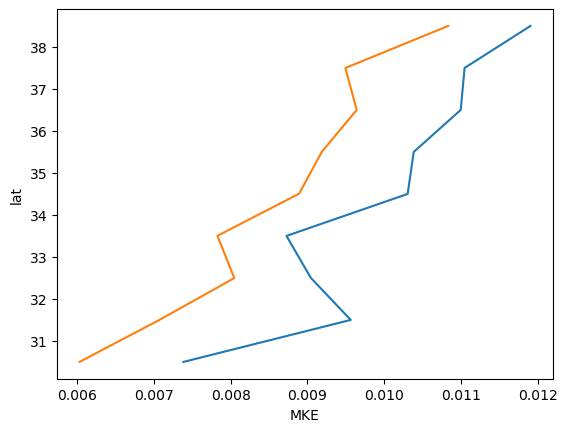

In [93]:
_dfE_mean.mean('lon').MKE.plot(y='lat')
_dfE_mean_lat.MKE.plot(y='lat')

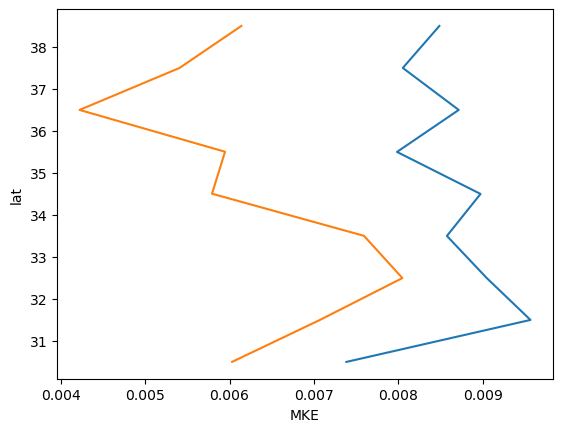

In [85]:
_dfE_mean.mean('lon').MKE.plot(y='lat')
_dfE_mean_lat.MKE.plot(y='lat')

In [63]:
_dfE_count = pa.add_geodata(_dfE_count,lonlat=['lon_cut','lat_cut'])
_dfE_count = (_dfE_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in ['lon_cut','lat_cut']])
         .to_xarray()
        )

<AxesSubplot:xlabel='lon_cut,lat_cut'>

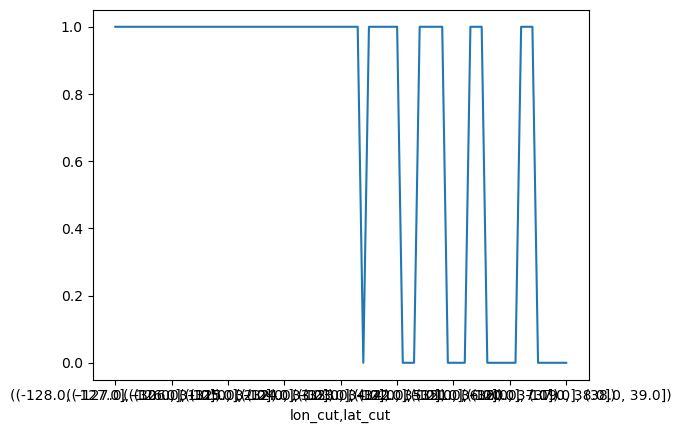

In [95]:
_dfE_count.zonal_velocity.plot(
                              )

In [ ]:
bbox = [-128, -118, 30, 40] # california
dl=.1
dfE_01dl = binned_mean(dfE_mean,dl,bbox,2,group,skipna=True)

### PDFs

In [ ]:
bbox = [-128, -118, 30, 40] # california
dl=1.
group = ['lon_cut','lat_cut']
#dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl_skipna = binned_mean(dfE_mean,dl,bbox,1,group,skipna=True)
dfE_1dl = binned_mean(dfE_mean,dl,bbox,1,group,skipna=False)
dfE_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])

In [11]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [12]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 
df= df.compute()

In [17]:
group=['lon_cut','lat_cut']
dfL_1dl_skipna,df_merged_skipna = binned_Lmean(df,1.,bbox,group=group,skipna=True)
dfL_1dl,df_merged = binned_Lmean(df,1.,bbox,group=group,skipna=False)

In [18]:
for V in [[dfE_1dl,dfL_1dl],[dfE_1dl_skipna,dfL_1dl_skipna]]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
    V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
    V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
    V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
    V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
    V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
    V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']

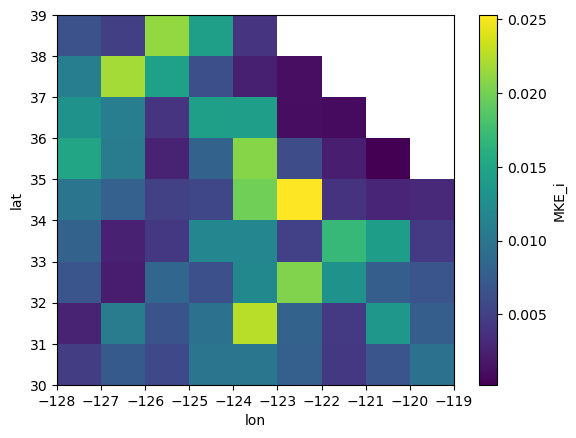

In [15]:
dfL_1dl.MKE_i.plot(y='lat')

In [43]:
(np.abs(dfL_1dl.MKE_i-dfE_1dl.MKE)/dfE_1dl.MKE).rename({'test'})

<xarray.DataArray {'test'} (lon: 9, lat: 9)>
array([[0.02611765, 0.06957806, 0.03996401, 0.00203664, 0.07177738,
        0.00219529, 0.00526383, 0.04805369, 0.03328209],
       [0.00890418, 0.00189672, 0.03882585, 0.03252353, 0.0471045 ,
        0.02844504, 0.02861282, 0.00443623, 0.17579092],
       [0.05210084, 0.01994741, 0.00348458, 0.10258406, 0.03182629,
        0.0693654 , 0.15783401, 0.038663  , 0.028448  ],
       [0.01153439, 0.0255534 , 0.04039219, 0.00778498, 0.02219228,
        0.00945942, 0.02546788, 0.05510184, 0.05413575],
       [0.00626993, 0.01917319, 0.00444566, 0.00367489, 0.03595514,
        0.01196284, 0.09062221, 0.07495033,        nan],
       [0.06287089, 0.09895395, 0.07433591, 0.04832087, 0.21125776,
        0.07569829,        nan,        nan,        nan],
       [0.06708315, 0.03588001, 0.01292013, 0.00921038, 0.80464265,
               nan,        nan,        nan,        nan],
       [0.03895897, 0.05812876, 0.08436165,        nan,        nan,
               nan,        nan,        nan,        nan],
       [0.03394431, 0.12057832, 0.08928775,        nan,        nan,
               nan,        nan,        nan,        nan]])
Coordinates:
  * lon      (lon) float64 -127.5 -126.5 -125.5 -124.5 ... -121.5 -120.5 -119.5
  * lat      (lat) float64 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5

In [55]:
_ds = xr.Dataset({'MKE_Ei':(np.abs(dfL_1dl.MKE_i-dfE_1dl.MKE)/dfE_1dl.MKE),
                  'MKE_Eb': (np.abs(dfL_1dl.MKE_b-dfE_1dl.MKE)/dfE_1dl.MKE),
                 'EKE_Ei': (np.abs(dfL_1dl.EKE_i-dfE_1dl.EKE)/dfE_1dl.EKE),
                  'EKE_Eb' : (np.abs(dfL_1dl.EKE_b-dfE_1dl.EKE)/dfE_1dl.EKE)})



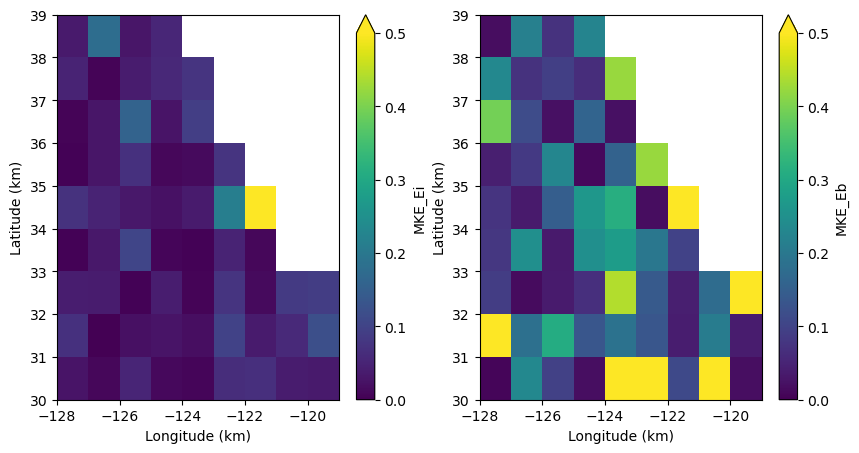

In [64]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
_ds.MKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
_ds.MKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
for a in ax:
    a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')

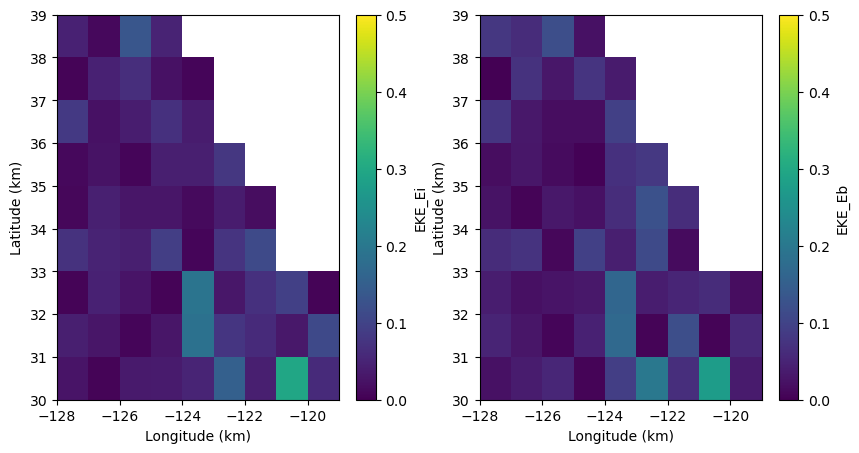

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
_ds.EKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
_ds.EKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
for a in ax:
    a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')

In [231]:
dls = np.linspace(0.1,2,20)
K = np.append(np.full(19,3),1)
_ds,dfE_dl,dfL_dl={},{},{}
for dl,k in zip(dls,K):
    dfE_dl[str(dl)] = binned_mean(dfE_mean,dl,bbox,k,group,skipna=False)
    dfL_dl[str(dl)],df_merged = binned_Lmean(df,dl,bbox,group=group,skipna=False)
    for V in [[dfE_dl[str(dl)],dfL_dl[str(dl)]]]:#,[dfE_01dl,dfL_01dl],[dfE_1dlat,dfL_1dlat],[dfE_01dlat,dfL_01dlat]]:
        V[0]['MKE'] = V[0]['zonal_velocity']**2+V[0]['meridional_velocity']**2
        V[0]['EKE'] = V[0]['zonal_velocity_var']+V[0]['meridional_velocity_var']
        V[1]['MKE_i'] = V[1]['zonal_velocity_mean']**2+V[1]['meridional_velocity_mean']**2
        V[1]['MKE_b'] = V[1]['zonal_velocity']**2+V[1]['meridional_velocity']**2
        V[1]['EKE_i'] = V[1]['zonal_velocity_var_itime']+V[1]['meridional_velocity_var_itime']
        V[1]['EKE_b'] = V[1]['zonal_velocity_var_binned']+V[1]['meridional_velocity_var_binned']
    _ds[str(dl)] = xr.Dataset({'MKE_Ei':(np.abs(dfL_dl[str(dl)].MKE_i-dfE_dl[str(dl)].MKE)/dfE_dl[str(dl)].MKE),
                  'MKE_Eb': (np.abs(dfL_dl[str(dl)].MKE_b-dfE_dl[str(dl)].MKE)/dfE_dl[str(dl)].MKE),
                 'EKE_Ei': (np.abs(dfL_dl[str(dl)].EKE_i-dfE_dl[str(dl)].EKE)/dfE_dl[str(dl)].EKE),
                  'EKE_Eb' : (np.abs(dfL_dl[str(dl)].EKE_b-dfE_dl[str(dl)].EKE)/dfE_dl[str(dl)].EKE)})

#### Notes : 


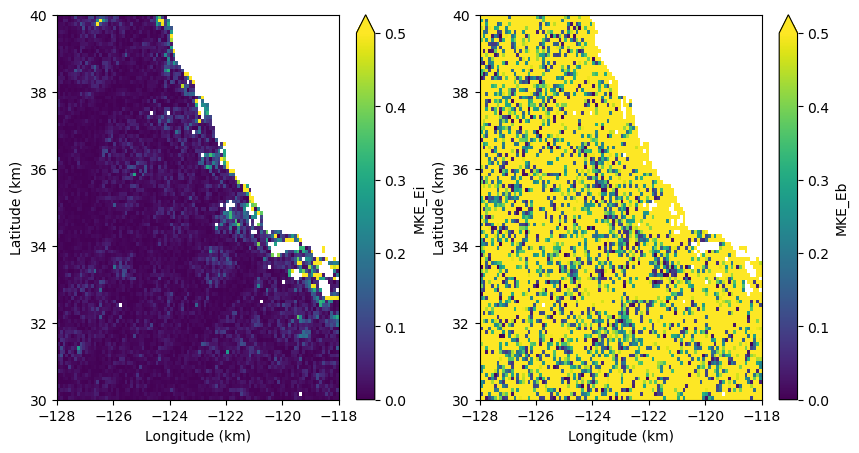

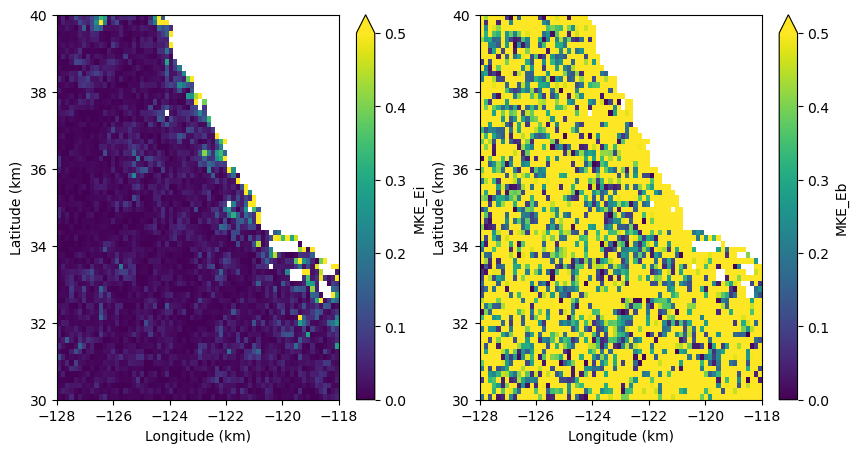

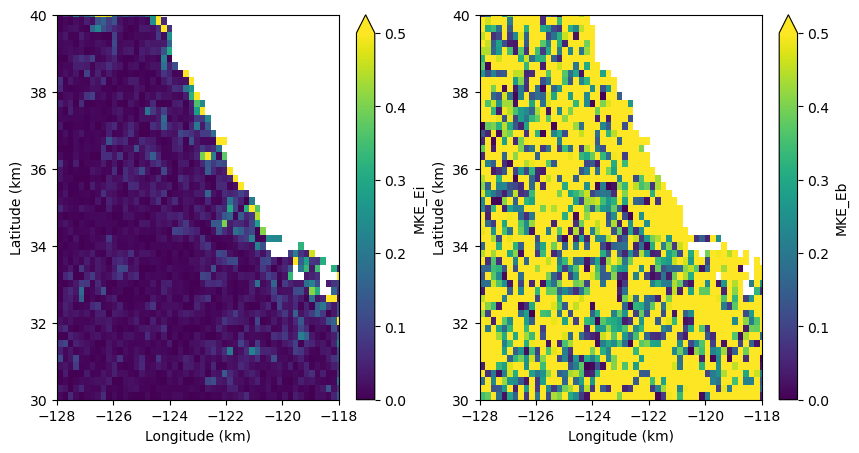

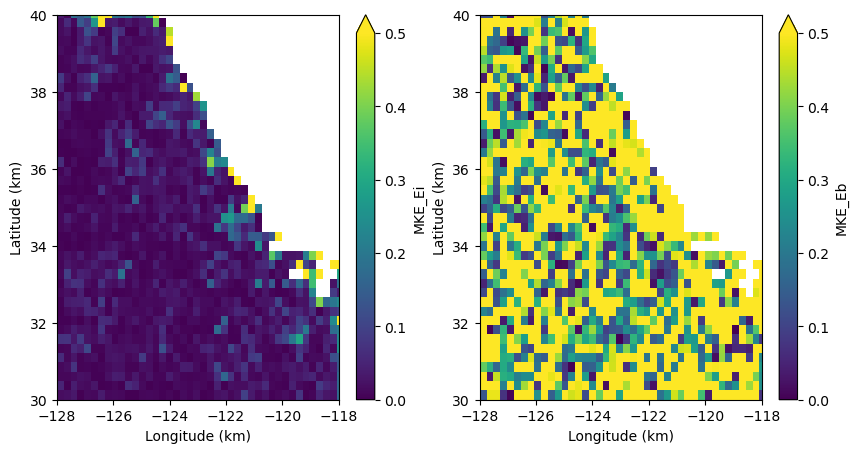

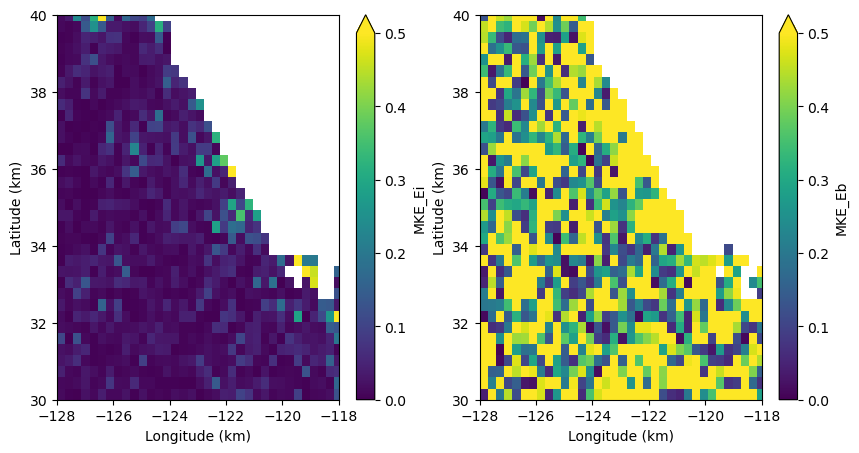

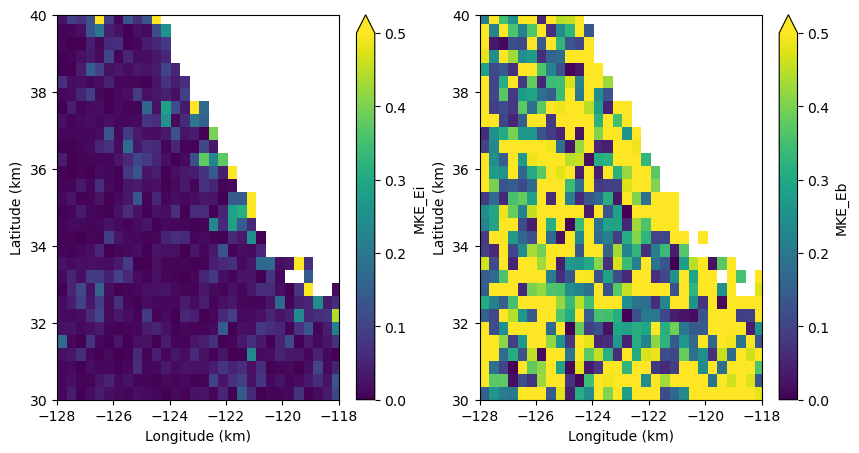

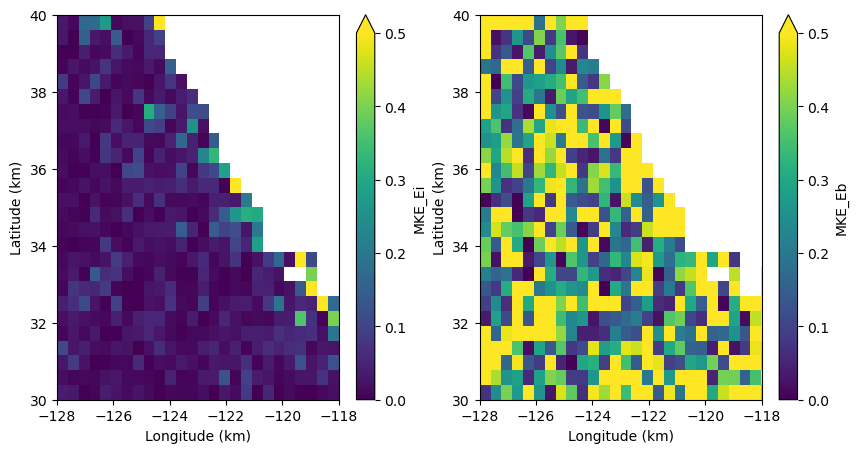

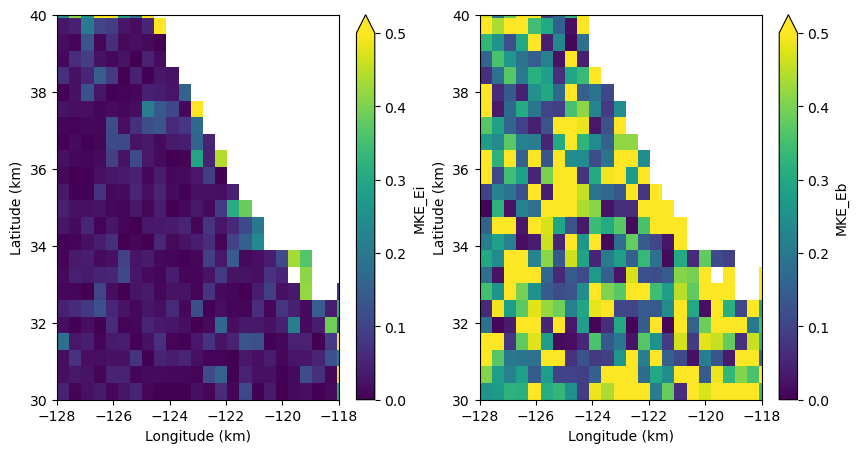

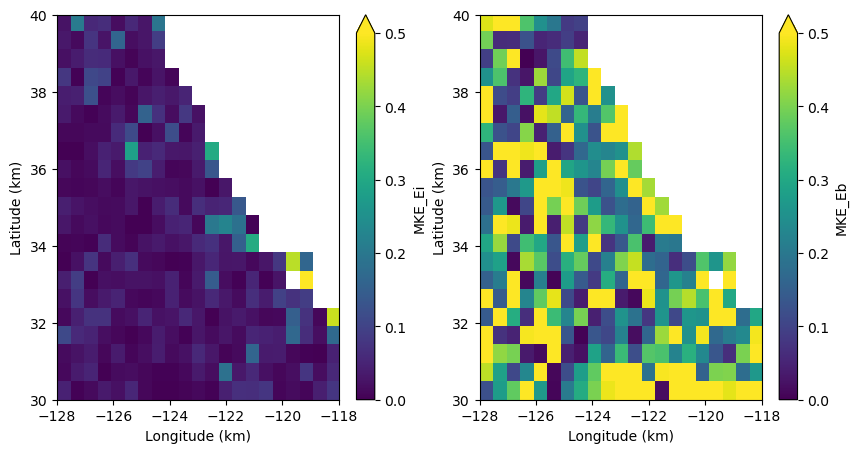

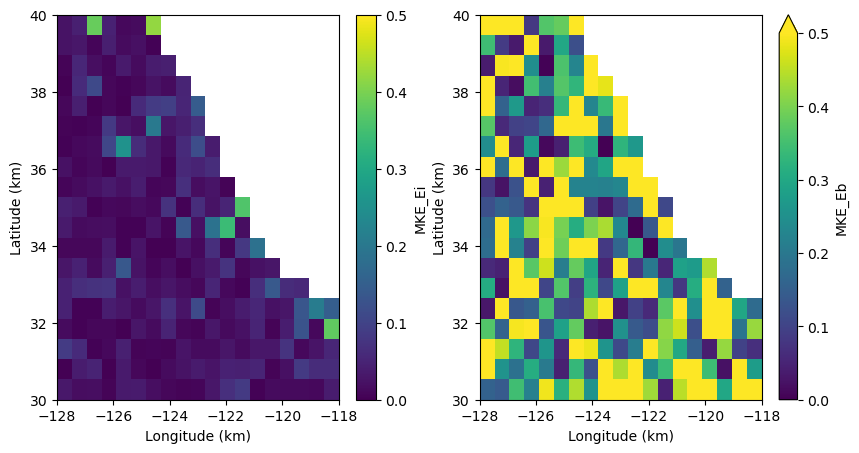

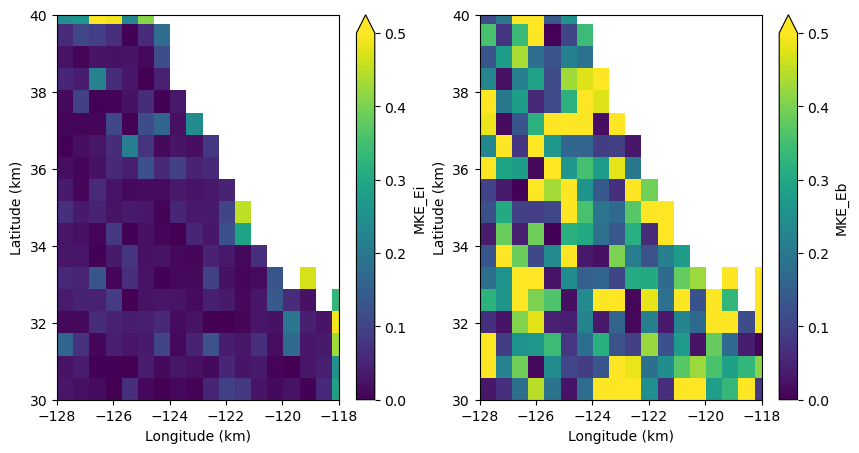

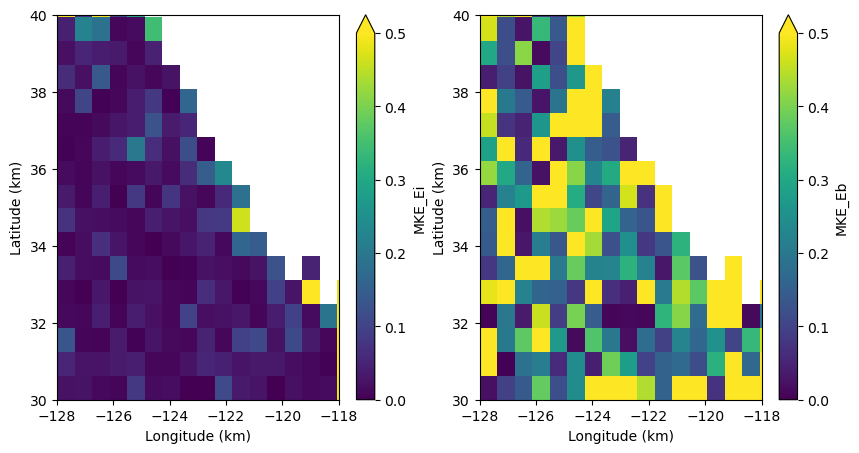

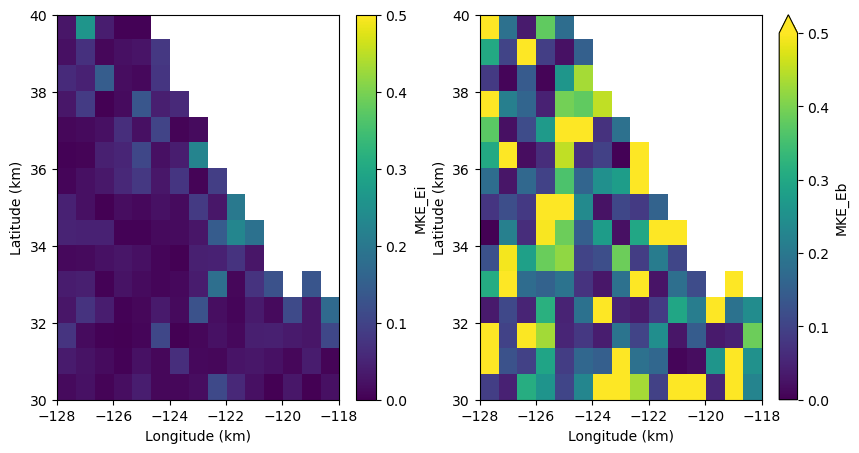

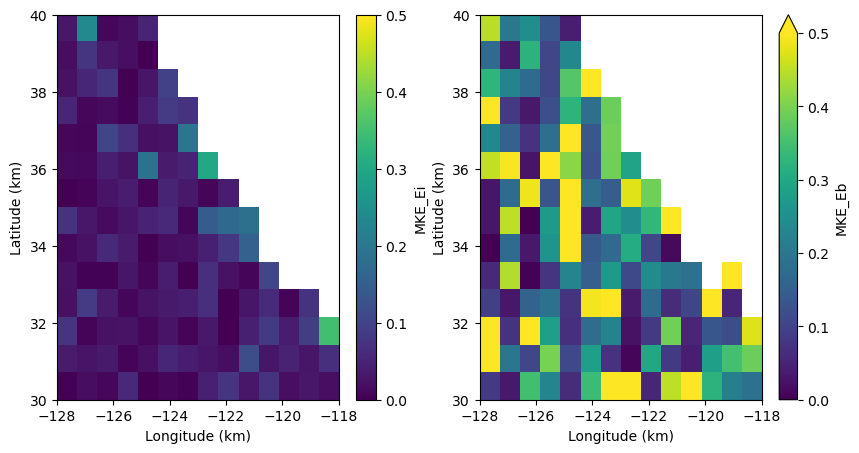

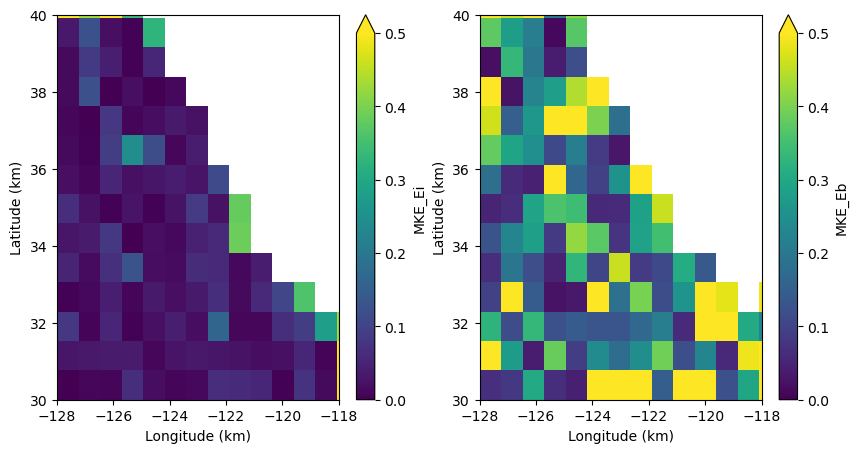

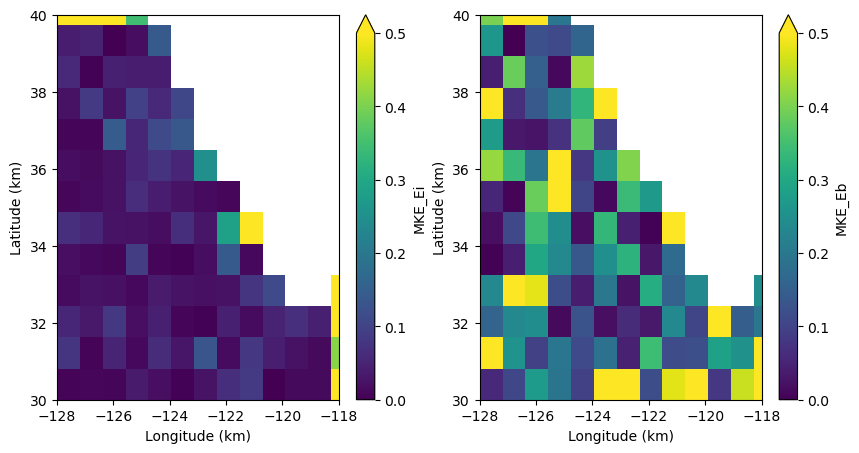

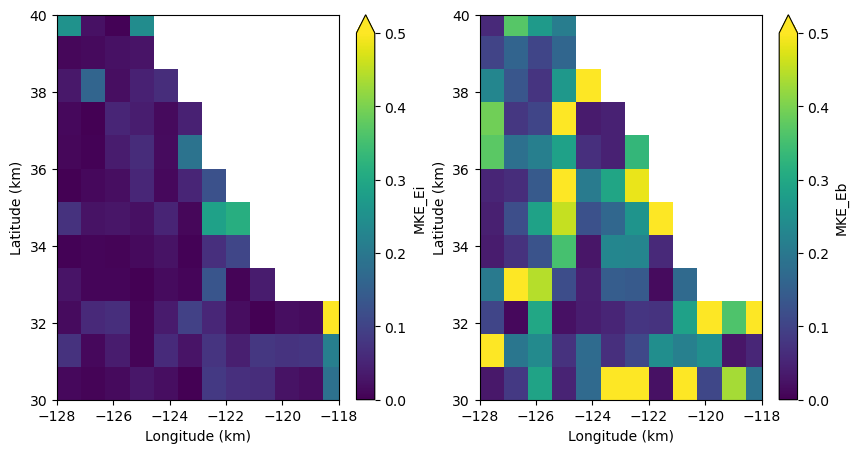

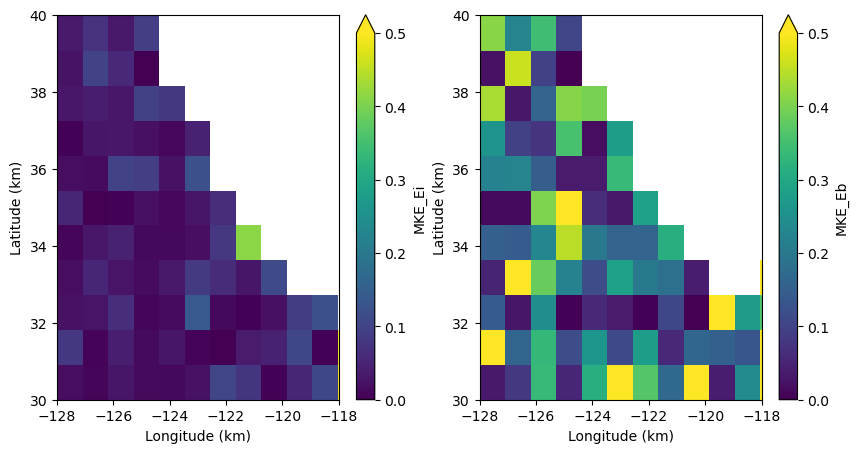

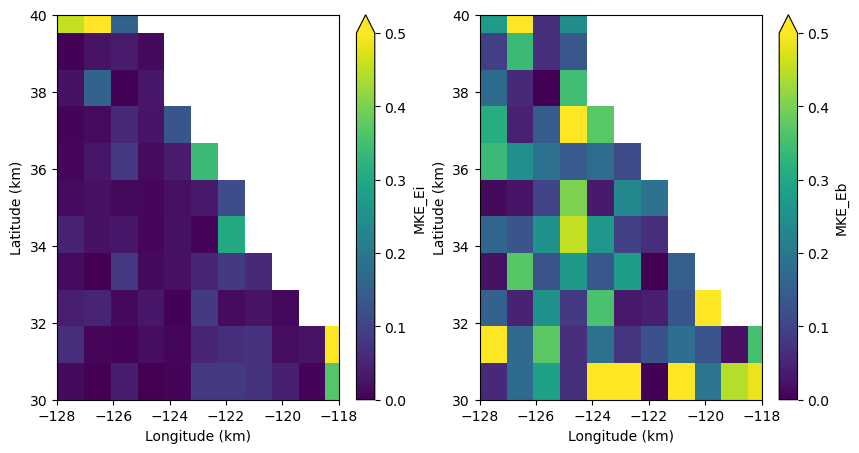

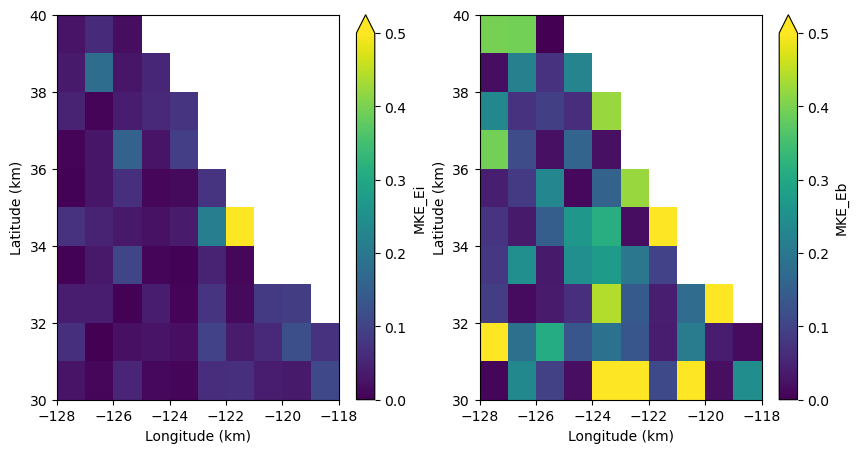

In [224]:
for dl in _ds.keys():
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    _ds[dl].MKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
    _ds[dl].MKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
    for a in ax:
        a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')
        a.set_xlim(bbox[0],bbox[1]);a.set_ylim(bbox[2],bbox[3])

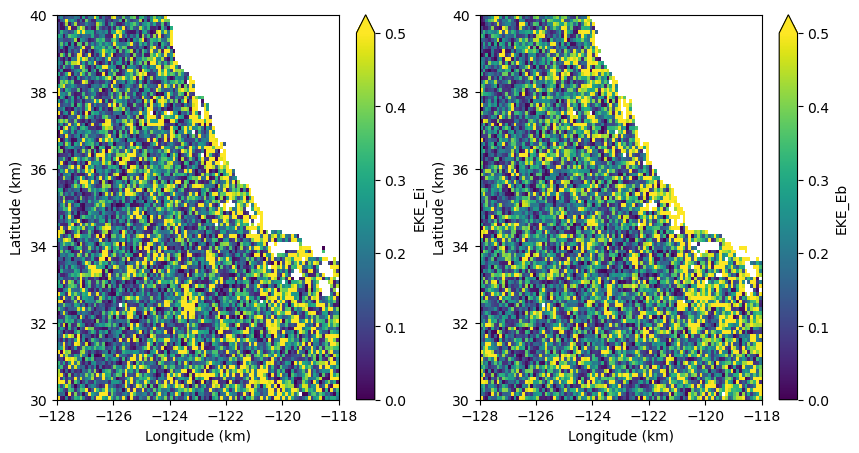

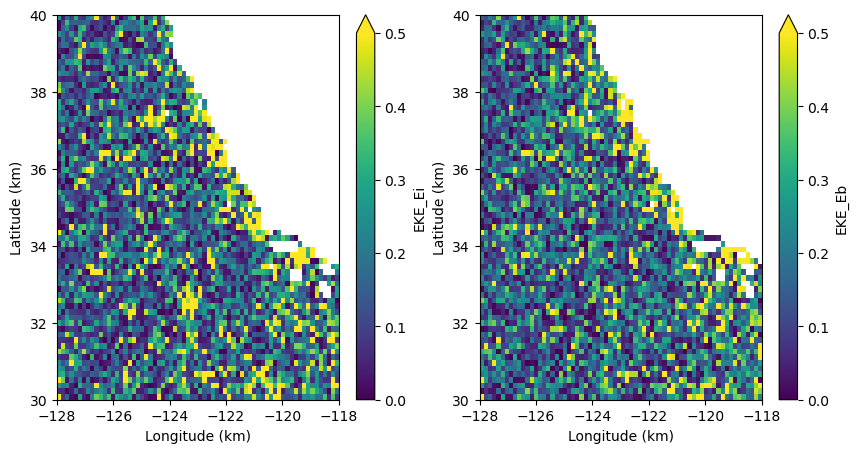

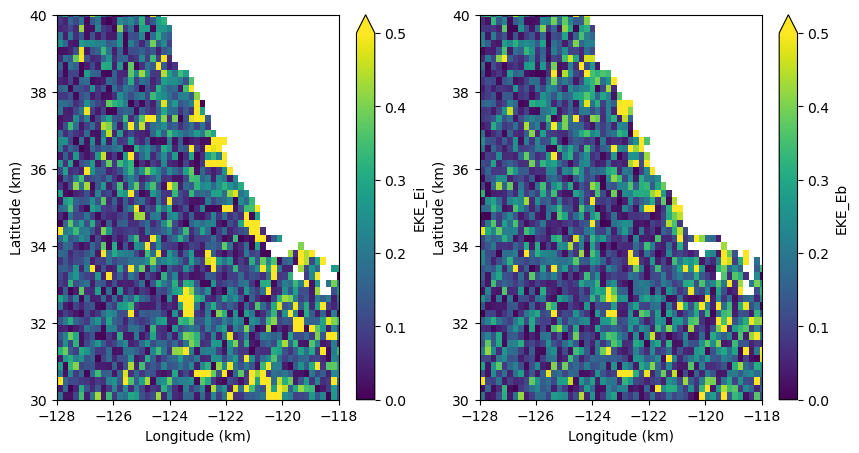

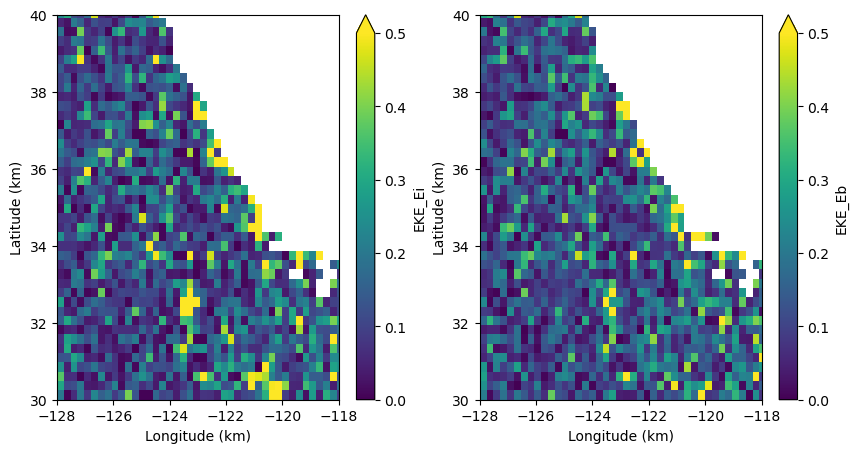

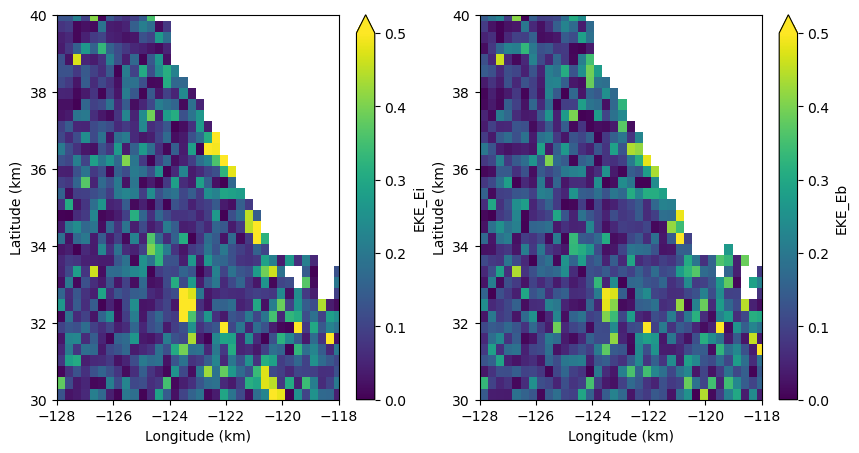

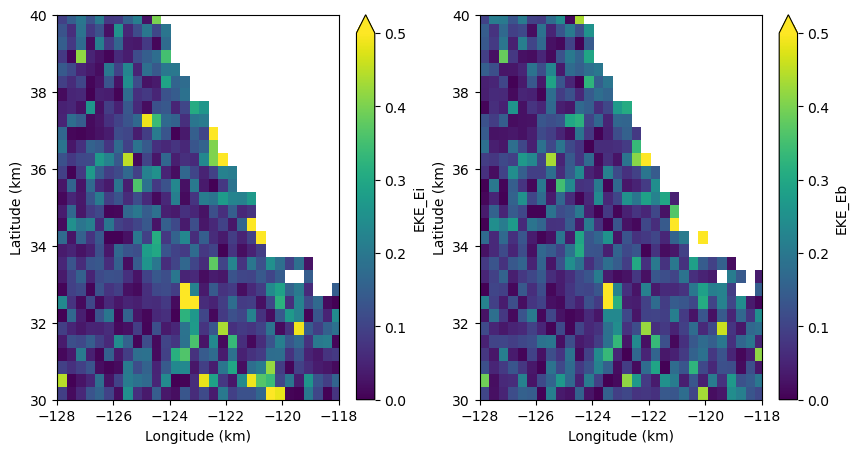

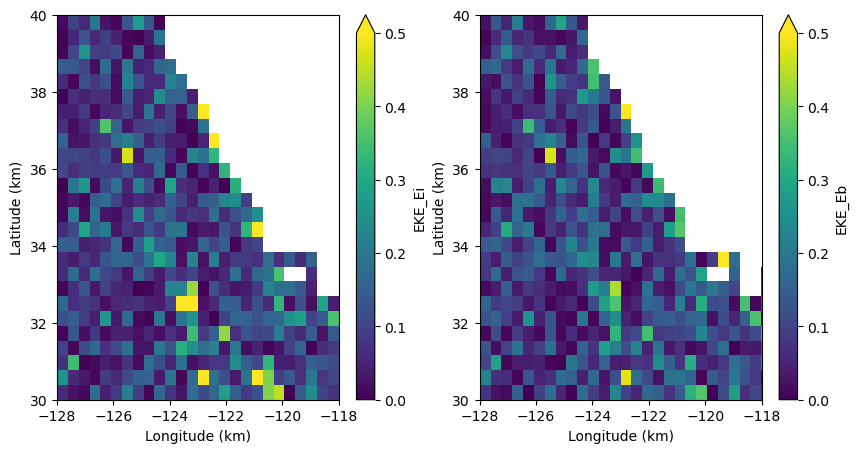

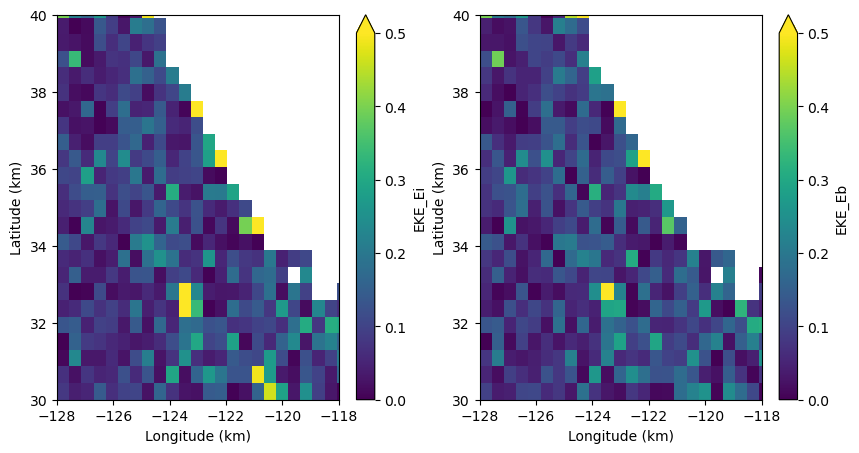

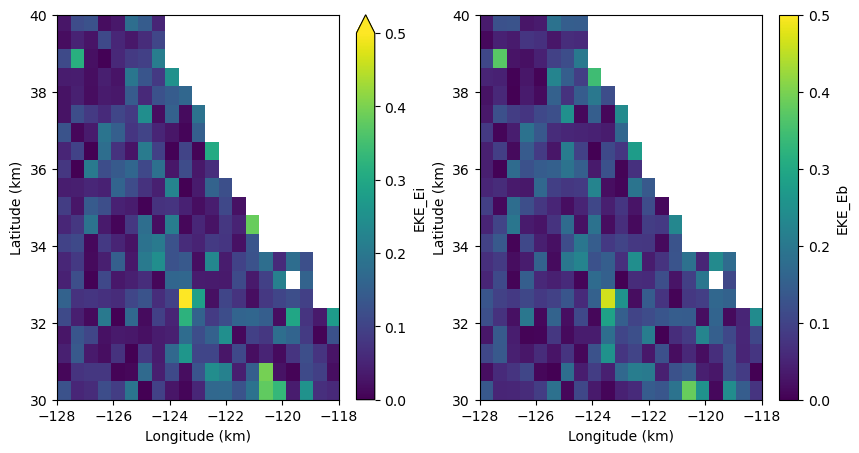

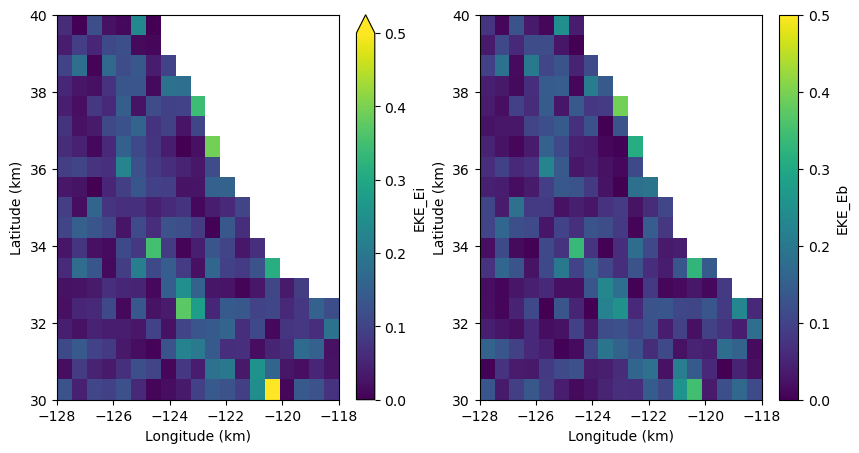

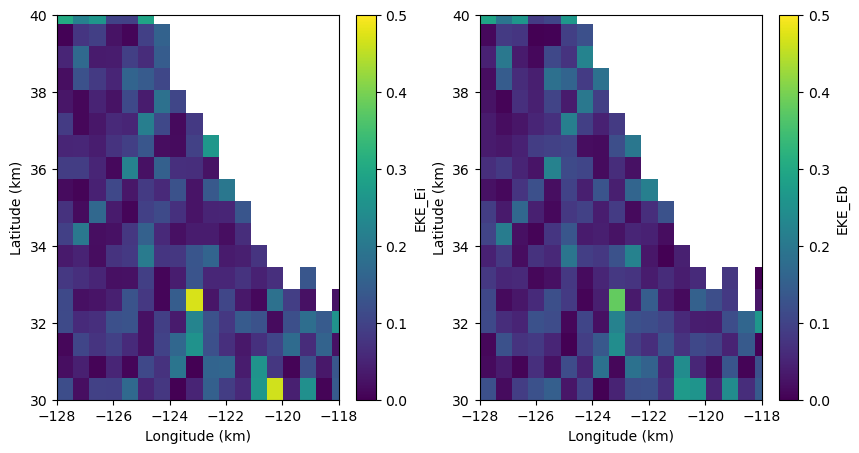

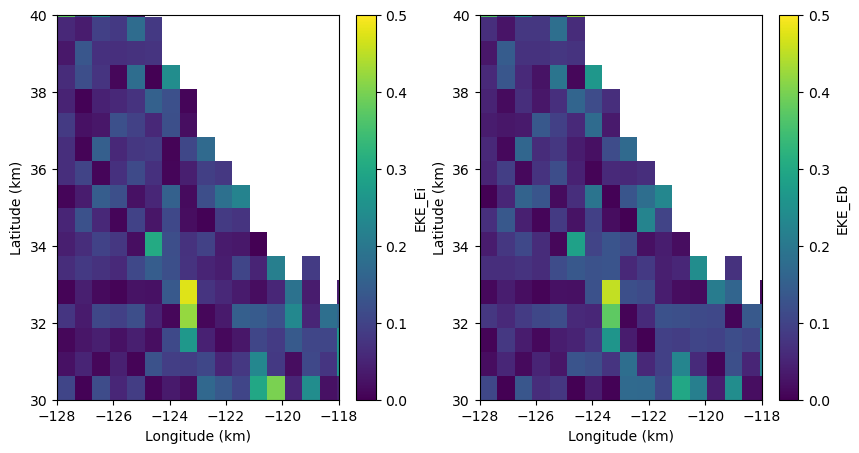

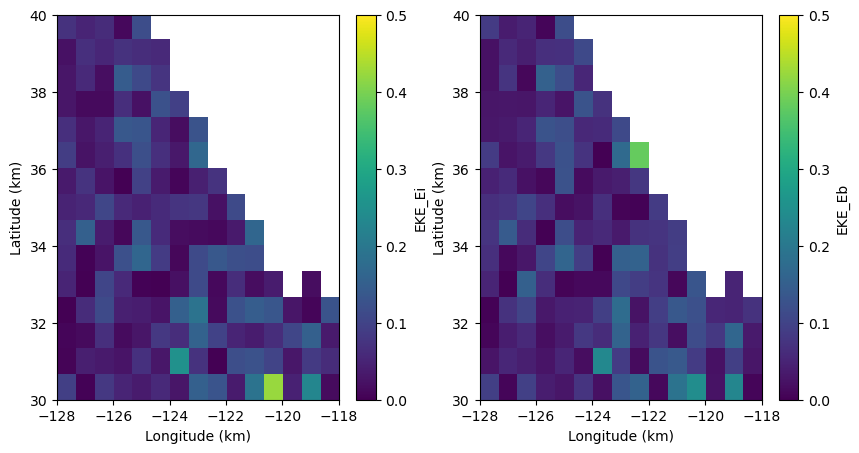

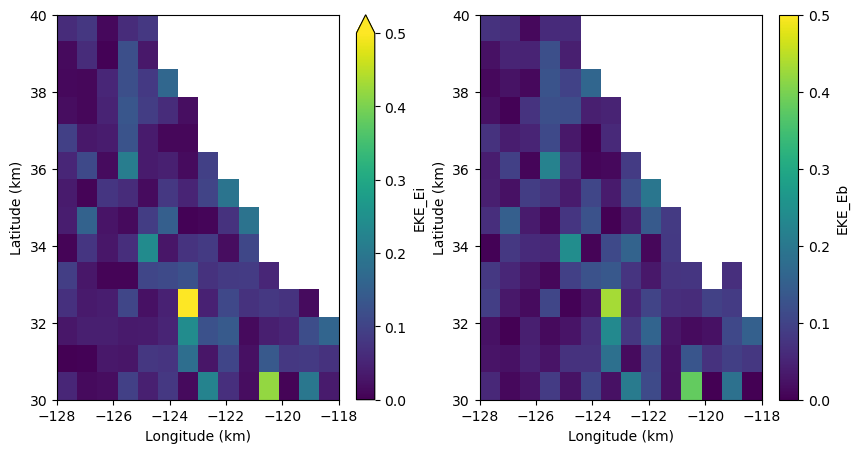

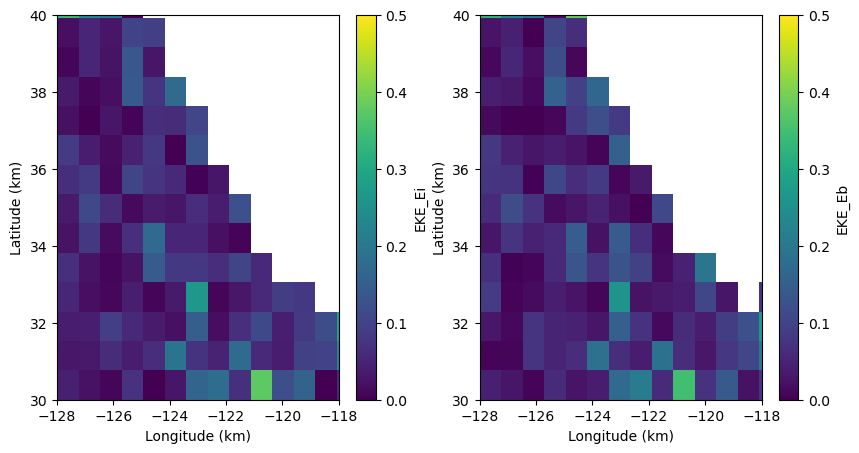

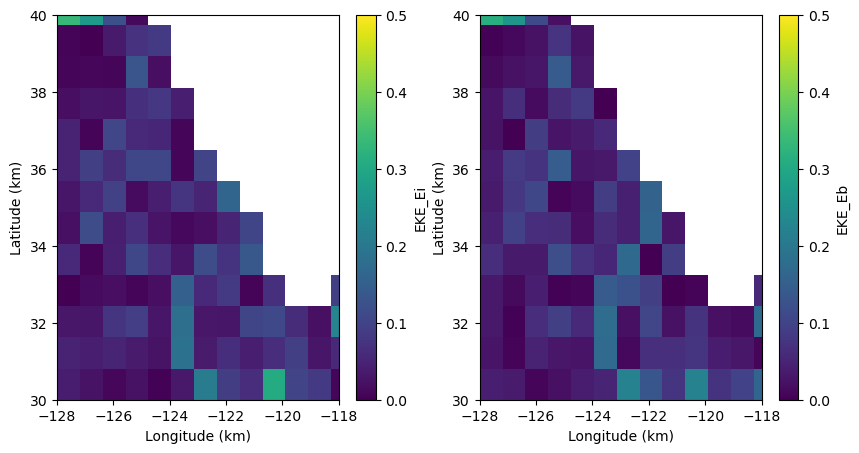

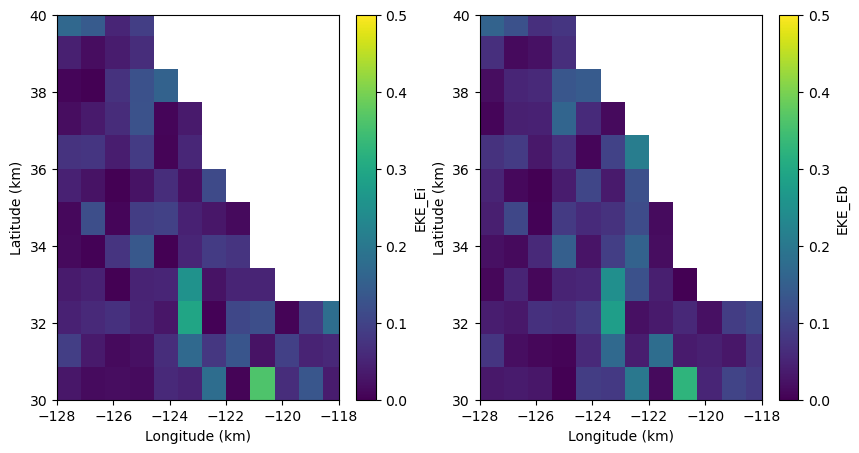

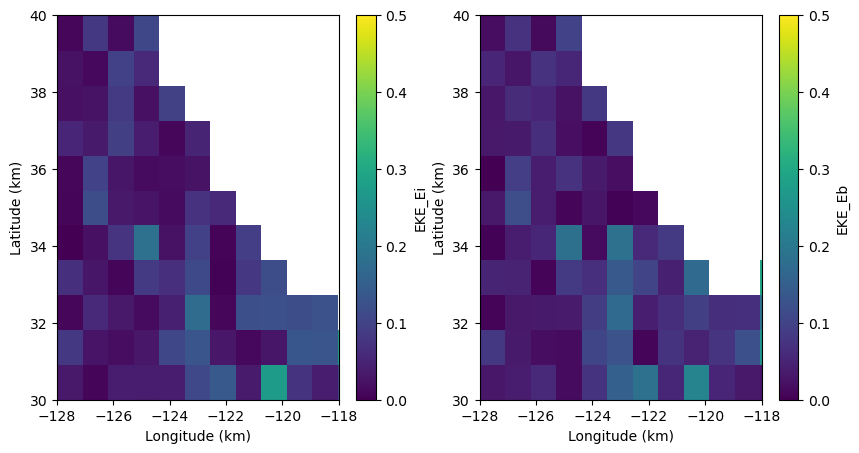

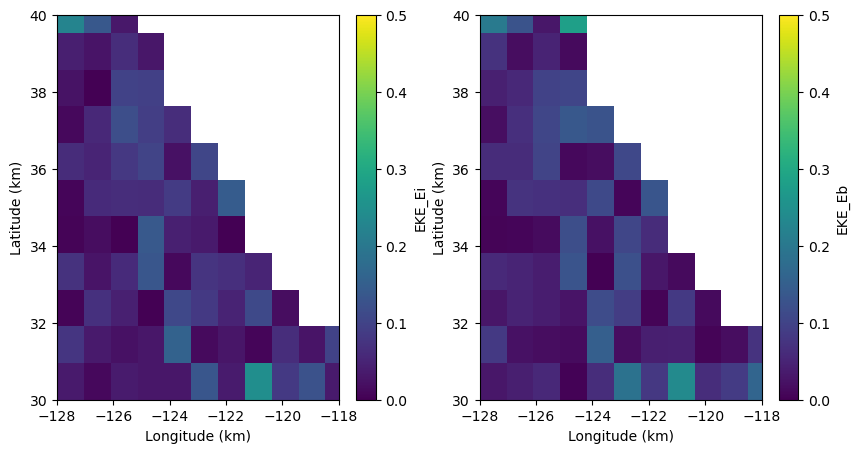

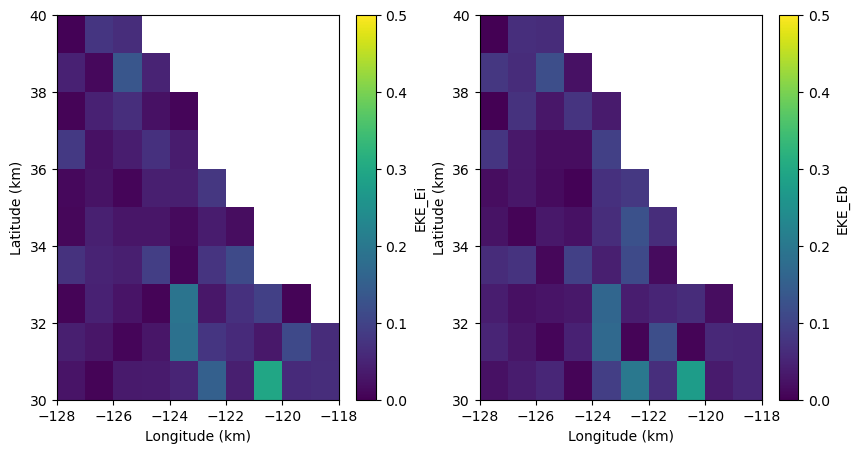

In [225]:
for dl in _ds.keys():
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    _ds[dl].EKE_Ei.plot(y='lat',ax=ax[0],vmin=0,vmax=0.5)
    _ds[dl].EKE_Eb.plot(y='lat',ax=ax[1],vmin=0,vmax=0.5)
    for a in ax:
        a.set_ylabel('Latitude (km)');a.set_xlabel('Longitude (km)')
        a.set_xlim(bbox[0],bbox[1]);a.set_ylim(bbox[2],bbox[3])

In [232]:
means = {'mean_'+V: list(_ds[key][V].mean().values for key in _ds.keys()) for V in _ds['0.1'].data_vars}

In [233]:
var = {'var_'+V: list(_ds[key][V].var().values for key in _ds.keys()) for V in _ds['0.1'].data_vars}

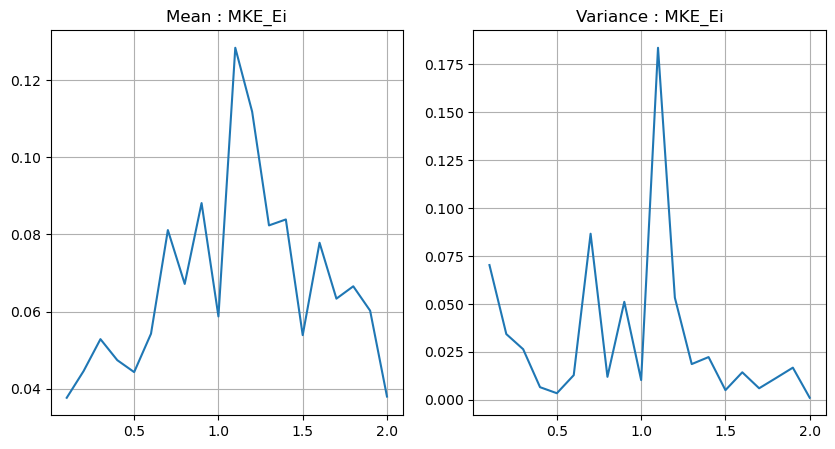

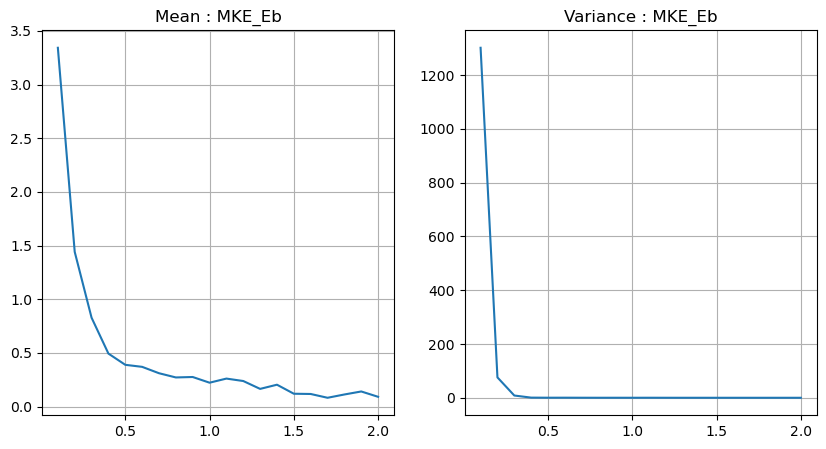

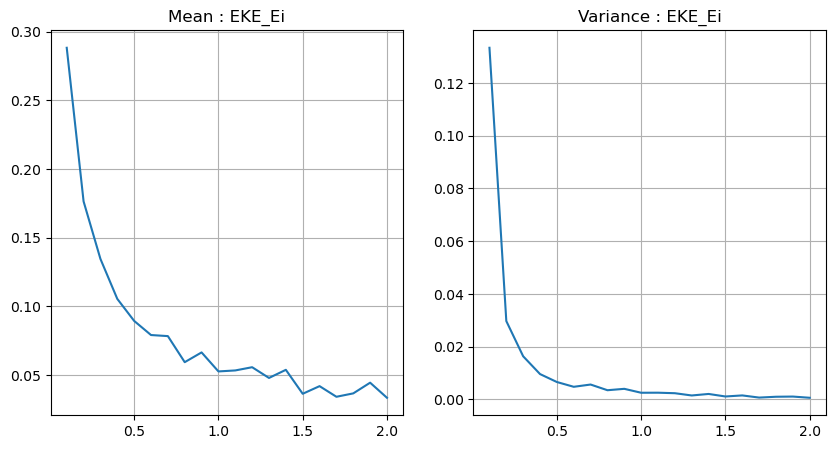

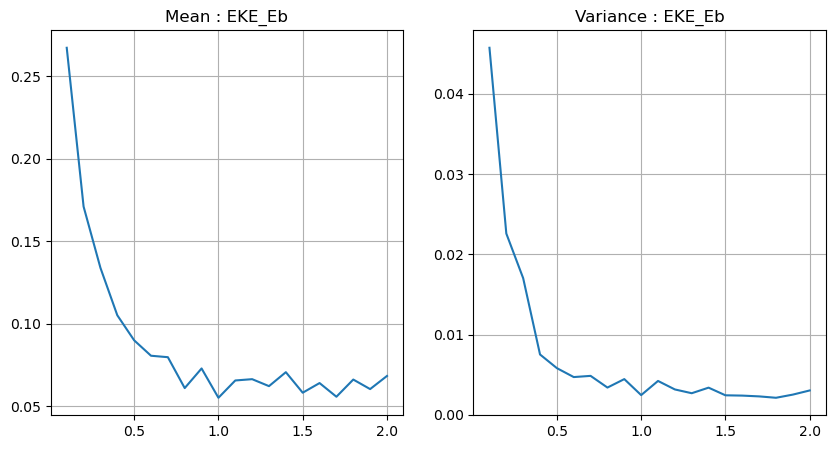

In [234]:
for key in means.keys():
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(dls,means['mean_'+key.split('_')[1]+'_'+key.split('_')[2]])
    ax[1].plot(dls,var['var_'+key.split('_')[1]+'_'+key.split('_')[2]])
    ax[0].grid();ax[1].grid();
    ax[0].set_title('Mean : ' +key.split('_')[1]+'_'+key.split('_')[2])
    ax[1].set_title('Variance : ' +key.split('_')[1]+'_'+key.split('_')[2])

In [235]:
cluster.close()